# DEEP LEARNING ASSIGNMENT

- ***Ayushmaand Das (I000452)***

## Problem Statement

- **Section 1 :**
  1. Choose a framework (Pytorch or TF) to train a LeNet/ResNet model with a classification dataset
  2. Report the F1 score after training until the training has saturated.
  3. Now tune the hyper parameters and report the new scores after every adjustment.
  4. Try data augmentations and report the scores.
  5. For the best model obtained, get the latency numbers (Time taken for processing a single sample)  


- **Section 2 :**
  1. Use TensorRT to accelerate the performance and report the new Latency.

## Section 1

#### Loading the Dataset (Fashion MNIST)


In [ ]:
import tensorflow as tf
from keras import layers, models
from sklearn.metrics import f1_score
import numpy as np
from keras import layers, models

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


#### Normalization and Reshaping

In [ ]:
x_train = x_train / 255.0
x_test = x_test / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


#### Building the Model

- Residual Blocks with Skip Connections

In [ ]:
def residual_block(x, filters, kernel_size=3, strides=1):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size=kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x

- Overall Architecture

In [ ]:
def build_resnet_34(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same', kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    for _ in range(3):
        x = residual_block(x, 64)

    x = residual_block(x, 128, strides=2)
    for _ in range(3):
        x = residual_block(x, 128)

    x = residual_block(x, 256, strides=2)
    for _ in range(5):
        x = residual_block(x, 256)

    x = residual_block(x, 512, strides=2)
    for _ in range(2):
        x = residual_block(x, 512)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

#### Model Compilation

In [ ]:
num_classes = 10
input_shape = x_train.shape[1:]

In [ ]:
model = build_resnet_34(input_shape, num_classes)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 14, 14, 64)     │          3,200 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 14, 14, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 14, 14, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 7, 7, 64)       │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 7, 7, 64)       │         36,928 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 7, 7, 64)       │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 7, 7, 64)       │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 7, 7, 64)       │         36,928 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 7, 7, 64)       │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 7, 7, 64)       │              0 │ batch_normalization_2… │
│                           │                        │                │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 7, 7, 64)       │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 7, 7, 64)       │         36,928 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 7, 7, 64)       │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 7, 7, 64)       │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 7, 7, 64)       │         36,928 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 21,309,066 (81.29 MB)

 Trainable params: 21,292,042 (81.22 MB)

 Non-trainable params: 17,024 (66.50 KB)

#### Model Training

- Adding a callback `EarlyStopping`: regularization technique, stops training a model when it starts to overfit

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(x_train, y_train, validation_split=0.1, epochs=50, batch_size=64, callbacks=[early_stopping])

Epoch 1/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 96s 57ms/step - accuracy: 0.7609 - loss: 0.7495 - val_accuracy: 0.8630 - val_loss: 0.3696
Epoch 2/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 30s 35ms/step - accuracy: 0.8772 - loss: 0.3411 - val_accuracy: 0.8475 - val_loss: 0.4863
Epoch 3/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 36s 30ms/step - accuracy: 0.8924 - loss: 0.3042 - val_accuracy: 0.8800 - val_loss: 0.3183
Epoch 4/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - accuracy: 0.9081 - loss: 0.2498 - val_accuracy: 0.8757 - val_loss: 0.3589
Epoch 5/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - accuracy: 0.9088 - loss: 0.2476 - val_accuracy: 0.8903 - val_loss: 0.3043
Epoch 6/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 25s 29ms/step - accuracy: 0.9196 - loss: 0.2150 - val_accuracy: 0.8957 - val_loss: 0.2985
Epoch 7/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - accuracy: 0.9222 - loss: 0.2221 - val_accuracy: 0.9005 - val_loss: 0.2727
Epoch 8/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - accuracy: 0.9335 - loss: 0.1797 - 

- Saving the model in `.h5` format

In [ ]:
model.save('resnet34_fashion_mnist.h5')

- Dowloading the model

In [ ]:
from google.colab import files
files.download('resnet34_fashion_mnist.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Calculation F1 Score and other metrics

In [ ]:
y_pred = np.argmax(model.predict(x_test), axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step


In [ ]:
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"F1 SCORE: {f1:.4f}")

F1 SCORE: 0.8948


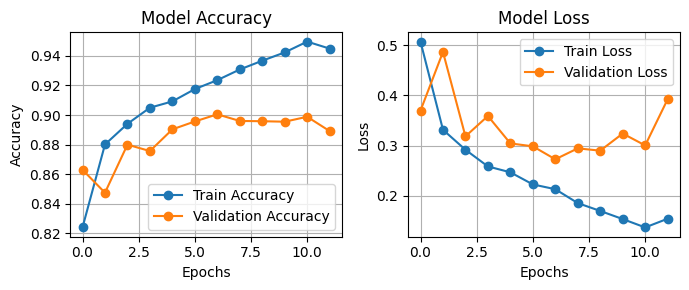

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    fig, axes = plt.subplots(1, 2, figsize=(7, 3))
    axes[0].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid()

    axes[1].plot(history.history['loss'], label='Train Loss', marker='o')
    axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='o')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid()

    plt.tight_layout()
    plt.show()
plot_metrics(history)

#### Making a prediction

In [ ]:
import cv2
from keras.preprocessing.image import img_to_array

def make_prediction(model, image_path):

  class_labels = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
  ]

  image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  image_org = image
  image = cv2.resize(image, (28, 28))

  image = image / 255.0

  image = np.expand_dims(image, axis=-1)
  image = np.expand_dims(image, axis=0)

  y_pred = np.argmax(model.predict(image), axis=1)
  return image_org, class_labels[y_pred[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


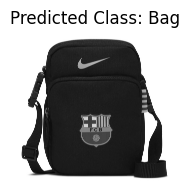

In [ ]:
from keras.models import load_model
model = load_model('resnet34_fashion_mnist.h5')

image, prediction = make_prediction(model, '/content/329d5ba8f2ca.png')

plt.figure(figsize=(2, 2))
plt.imshow(image, cmap='gray')
plt.title(f'Predicted Class: {prediction}')
plt.axis('off')
plt.show()

#### Performing Hyperparameter Tuning
- Added Stochastic Gradient Descent Optimzer
- Adjusted Learning Rate
- Adjusted Batch Size
- Adjusted Validation Data split
- Changed number of epochs

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_hypTuned = model.fit(x_train, y_train, validation_split=0.25, epochs=10, batch_size=128, callbacks=[early_stopping])

Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 89s 122ms/step - accuracy: 0.1396 - loss: 3.3935 - val_accuracy: 0.2809 - val_loss: 2.1779
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 35s 38ms/step - accuracy: 0.3434 - loss: 2.1203 - val_accuracy: 0.4544 - val_loss: 1.6964
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.4971 - loss: 1.5168 - val_accuracy: 0.5481 - val_loss: 1.3664
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.5823 - loss: 1.2272 - val_accuracy: 0.6031 - val_loss: 1.1851
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.6341 - loss: 1.0698 - val_accuracy: 0.6360 - val_loss: 1.0796
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.6685 - loss: 0.9652 - val_accuracy: 0.6595 - val_loss: 1.0047
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.6965 - loss: 0.8759 - val_accuracy: 0.6747 - val_loss: 0.9553
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.7136 - loss: 0.8145 -

In [ ]:
model.save('hypertuned_resnet34_fashion_mnist.h5')

y_pred_hypTuned = np.argmax(model.predict(x_test), axis=1)
f1_hypTuned = f1_score(y_test, y_pred_hypTuned, average='weighted')

print(f"NEW F1 SCORE WITH HYPERTUNED MODEL: {f1_hypTuned:.4f}")

In [ ]:
tf.saved_model.save(model, "hypertuned_resnet34_fashion_mnist")

#### Performing Data Augmentation and Re-Training

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1
)
datagen.fit(x_train)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_augmented = model.fit(datagen.flow(x_train, y_train, batch_size=128), validation_data=(x_test, y_test), epochs=30, callbacks=[early_stopping])

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 62ms/step - accuracy: 0.7835 - loss: 0.7401 - val_accuracy: 0.9121 - val_loss: 0.2992
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - accuracy: 0.7907 - loss: 0.6922 - val_accuracy: 0.9121 - val_loss: 0.2919
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.7979 - loss: 0.6448 - val_accuracy: 0.9120 - val_loss: 0.2860
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 82ms/step - accuracy: 0.7983 - loss: 0.6172 - val_accuracy: 0.9124 - val_loss: 0.2811
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - accuracy: 0.8033 - loss: 0.6055 - val_accuracy: 0.9128 - val_loss: 0.2764


In [ ]:
y_pred_augmented = np.argmax(model.predict(x_test), axis=1)
f1_augmented = f1_score(y_test, y_pred_augmented, average='weighted')
print(f"New F1 Score with data augmentation: {f1_augmented:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
New F1 Score with data augmentation: 0.9126


#### Comparison of the three models

Text(0.5, 0, 'Epochs')

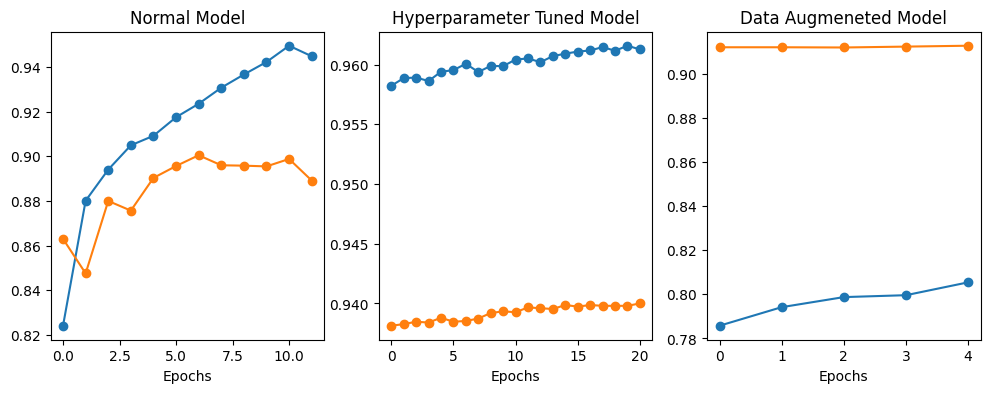

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1,3,1)
plt.title("Normal Model")
plt.plot(history.history['accuracy'], label='Train Accuracy)', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')

plt.subplot(1,3,2)
plt.title("Hyperparameter Tuned Model")
plt.plot(history_hypTuned.history['accuracy'], label='Train Accuracy)', marker='o')
plt.plot(history_hypTuned.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')

plt.subplot(1,3,3)
plt.title("Data Augmeneted Model")
plt.plot(history_augmented.history['accuracy'], label='Train Accuracy)', marker='o')
plt.plot(history_augmented.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')

#### BEST MODEL
- <u>Hyper-paramter Tuned</u>
- (F1 Score: 0.9160)

### Making prediction for a single file and check metrics

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


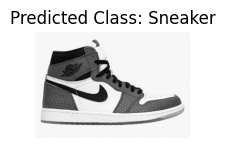

In [ ]:
from keras.models import load_model
model = load_model('/content/hypertuned_resnet34_fashion_mnist.h5')

import time

start_time = time.time()
image, prediction = make_prediction(model, '/content/jordans.jpeg')
end_time = time.time()

plt.figure(figsize=(2, 2))
plt.imshow(image, cmap='gray')
plt.title(f'Predicted Class: {prediction}')
plt.axis('off')
plt.show()

- Latency Measure

In [ ]:
print(f"Latency (Time taken for processing a single sample): {(end_time-start_time):.6f} seconds")

Latency (Time taken for processing a single sample): 2.264114 seconds


<hr>

## Section 2

#### Converting model from `.h5` format to `.onnx` format

In [ ]:
!pip install --upgrade tf2onnx onnx

- CLI Command for conversion

In [ ]:
!python -m tf2onnx.convert --saved-model /content/hypertuned_resnet34_fashion_mnist --output hypertuned_resnet34_fashion_mnist.onnx --opset 13

In [ ]:
import onnx
onnx_model = onnx.load("/content/hypertuned_resnet34_fashion_mnist.onnx")
onnx.checker.check_model(onnx_model)
print("ONNX model is valid.")

ONNX model is valid.


#### Converting `.onnx` model to `.trt` for Inference using TensorRT

In [1]:
!pip install tensorrt==10.0.1

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for tensorrt: filename=tensorrt-10.0.1-py2.py3-none-any.whl size=16331 sha256=a5b79394149c3f02c5f1e85e49029591d2a4db7be2a4f6f67067d2b47559f3b6
  Stored in directory: /root/.cache/pip/wheels/31/90/ef/53ad98d9a1bd660c0177aa1ea91bde288edfbe4d15621ca472
  Created wheel for tensorrt-cu12: filename=tensorrt_cu12-10.8.0.43-py2.py3-none-any.whl size=17595 sha256=f987464a4b3722c9d7a6e6a3cbbb34c40c079f4278b449a30495464be4c17816
  Stored in directory: /root/.cache/pip/wheels/ef/cf/7c/93e4012a84c44ffa5cf2a6a7ea03b282a8a19e17755808a9fb
Successfully built tensorrt tensorrt-cu12


- Fetching and Extracting the ***TensorRT tarball***

In [ ]:
!wget https://developer.nvidia.com/downloads/compute/machine-learning/tensorrt/10.0.0/tars/TensorRT-10.0.0.6.Linux.x86_64-gnu.cuda-12.4.tar.gz -O tensorrt.tar.gz

--2025-01-24 10:02:32--  https://developer.nvidia.com/downloads/compute/machine-learning/tensorrt/10.0.0/tars/TensorRT-10.0.0.6.Linux.x86_64-gnu.cuda-12.4.tar.gz
Resolving developer.nvidia.com (developer.nvidia.com)... 23.52.40.73, 23.52.40.58
Connecting to developer.nvidia.com (developer.nvidia.com)|23.52.40.73|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://developer.download.nvidia.com/compute/machine-learning/tensorrt/10.0.0/tars/TensorRT-10.0.0.6.Linux.x86_64-gnu.cuda-12.4.tar.gz [following]
--2025-01-24 10:02:33--  https://developer.download.nvidia.com/compute/machine-learning/tensorrt/10.0.0/tars/TensorRT-10.0.0.6.Linux.x86_64-gnu.cuda-12.4.tar.gz
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 23.52.40.73, 23.52.40.58
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|23.52.40.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2348693005 (2.2G) [appli

In [ ]:
!tar -xzvf tensorrt.tar.gz

- Set up environment variables and convert

In [ ]:
import os
os.environ['LD_LIBRARY_PATH'] = '/content/TensorRT-10.0.0.6/lib:/content/TensorRT-10.0.0.6/lib/plugins:' + os.environ.get('LD_LIBRARY_PATH', '')

### TensorRT Optimization and Inference

In [ ]:
!/content/TensorRT-10.0.0.6/bin/trtexec --onnx=hypertuned_resnet34_fashion_mnist.onnx --saveEngine=hypertuned_resnet34_fashion_mnist.trt


&&&& RUNNING TensorRT.trtexec [TensorRT v100000] # /content/TensorRT-10.0.0.6/bin/trtexec --onnx=hypertuned_resnet34_fashion_mnist.onnx --saveEngine=hypertuned_resnet34_fashion_mnist.trt
[01/24/2025-10:17:38] [I] === Model Options ===
[01/24/2025-10:17:38] [I] Format: ONNX
[01/24/2025-10:17:38] [I] Model: hypertuned_resnet34_fashion_mnist.onnx
[01/24/2025-10:17:38] [I] Output:
[01/24/2025-10:17:38] [I] === Build Options ===
[01/24/2025-10:17:38] [I] Memory Pools: workspace: default, dlaSRAM: default, dlaLocalDRAM: default, dlaGlobalDRAM: default, tacticSharedMem: default
[01/24/2025-10:17:38] [I] avgTiming: 8
[01/24/2025-10:17:38] [I] Precision: FP32
[01/24/2025-10:17:38] [I] LayerPrecisions: 
[01/24/2025-10:17:38] [I] Layer Device Types: 
[01/24/2025-10:17:38] [I] Calibration: 
[01/24/2025-10:17:38] [I] Refit: Disabled
[01/24/2025-10:17:38] [I] Strip weights: Disabled
[01/24/2025-10:17:38] [I] Version Compatible: Disabled
[01/24/2025-10:17:38] [I] ONNX Plugin InstanceNorm: Disabled
[0

<hr>